In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import artm

# change log style
lc = artm.messages.ConfigureLoggingArgs()
lc.minloglevel = 3
lib = artm.wrapper.LibArtm(logging_config=lc)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from copy import deepcopy
from topicnet.cooking_machine.models.topic_model import TopicModel
from topicnet.cooking_machine.cubes import RegularizersModifierCube
from topicnet.cooking_machine.config_parser import build_experiment_environment_from_yaml_config
from topicnet.cooking_machine.experiment import Experiment
from topicnet.cooking_machine.cubes import *
from topicnet.cooking_machine.dataset import Dataset
from topicnet.cooking_machine.pretty_output import make_notebook_pretty
make_notebook_pretty()

In [3]:
import topicnet.cooking_machine.cubes as tncubes

In [4]:
from IPython.core.display import display, HTML
from IPython.display import clear_output, display_html
display(HTML("""<style>
.container { width:90% !important; }
div.output_scroll .output_subarea { white-space: pre; }
</style>"""))

### Make initial model

In [5]:
with open("/home/sultan/recipes/exploratory_search-variant1_success.yml", "r") as f:
    yaml_string = f.read()

DATASET_PATH = "/home/sultan/datasets/PScience/PScience.csv"
specific_topics = [f'topic_{i}' for i in range(35)]
background_topics = [f'bcg_{i}' for i in range(len(specific_topics),len(specific_topics) + 1)]

yaml_string = yaml_string.format(
    modality1='@word',
    modality2='@2gramm',
    dataset_path=DATASET_PATH,
    specific_topics=specific_topics,
    background_topics=background_topics)

print(yaml_string)

# This config follows a strategy described in the article
# Multi-objective Topic Modeling for Exploratory Search in Tech News
# by Anastasya Yanina, Lev Golitsyn and Konstantin Vorontsov, Jan 2018


# Use .format(modality=modality, dataset_path=dataset_path,
# specific_topics=specific_topics, background_topics=background_topics)
# when loading the recipe to adjust for your dataset

topics:
# Describes number of model topics, in the actuall article 200 topics were found to be optimal
    specific_topics: ['topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34']
    background_topics: ['bcg_35']

regularizers:
- DecorrelatorPhiRegularizer:


### Define Topic Model

In [6]:
from topicnet.cooking_machine.experiment import Experiment
if os.path.exists(f'./ExploratoryResearchDemo') == True:
    os.system("rm -rf ./ExploratoryResearchDemo")
experiment, dataset = build_experiment_environment_from_yaml_config(
    yaml_string,
    experiment_id='ExploratoryResearchDemo',
    save_path='ExploratoryResearchDemo',
)

In [7]:
experiment.run(dataset)

/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Perplexity is too high for threshold 1.05
  warnings.warn(warning_message)
/home/sultan/miniconda3/lib/python3.6/site-packages/topicnet/cooking_machine/cubes/base_cube.py:206: UserWarning: Max progression length exceeded
  warnings.warn(warning_message)


{<topicnet.cooking_machine.models.topic_model.TopicModel at 0x7ff59dd20390>}

In [8]:
experiment.show()

Experiment ExploratoryResearchDemo

Experiment was made with BigARTM 0.9.0
Tree:
                              ┌##00h24m35s_25d11m2019y###
                              ├##00h24m52s_25d11m2019y###
<<<<<<<<<<<root>>>>>>>>>>>────┤
                              ├##00h25m08s_25d11m2019y###
                              │                                                                                                                                                                                                                                                                                                                       ┌##00h32m18s_25d11m2019y###
                              │                                                                                                                                                                                                                                                                                                                       ├

In [9]:
best_model = experiment.select(experiment.criteria[-1][0])[0]

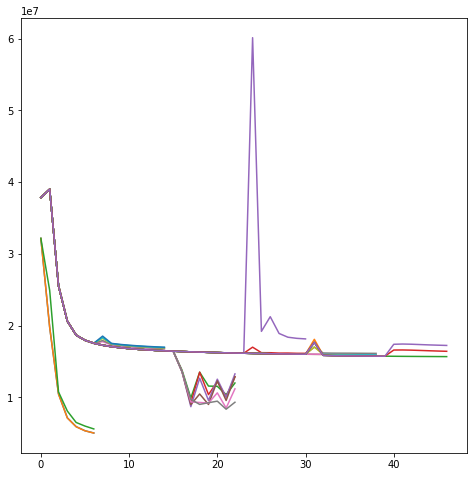

In [10]:
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['PerplexityScore@all']
    plt.plot(score[1:])
plt.show()

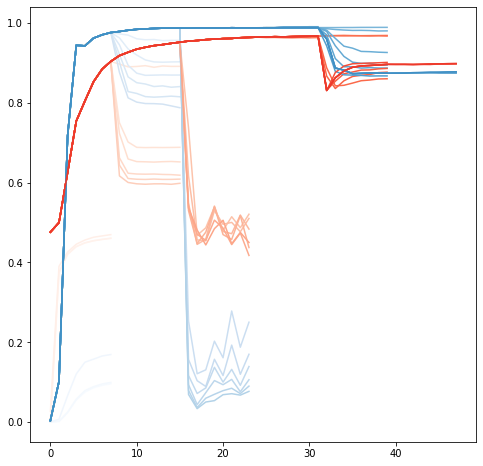

In [11]:
from matplotlib import cm
tms = experiment.models
colors = np.linspace(0, 0.65, len(tms))

plt.figure(figsize=(8,8))
for i, tm in enumerate(list(tms.values())[1:]):
    score = tm.scores['TopicKernel@word.average_purity']
    plt.plot(score, color=cm.Blues(colors[i]))
    score = tm.scores['TopicKernel@word.average_contrast']
    plt.plot(score, color=cm.Reds(colors[i]))
plt.show()

In [12]:
query = (
    "TopicKernel@word.average_contrast > 0.8 * MAXIMUM(TopicKernel@word.average_contrast) "
    "and TopicKernel@word.average_purity > 0.8 * MAXIMUM(TopicKernel@word.average_purity) "
    "and PerplexityScore@all < 1.1 * MINIMUM(PerplexityScore@all) "
)
models = experiment.select(query + " COLLECT all")
def describe_model(model):
    for reg_name, reg in model.regularizers._data.items():
        print(reg_name, reg.tau)
    print(model.scores["PerplexityScore@all"][-1])
    print(model.scores["TopicKernel@word.average_contrast"][-1])
    print(model.scores["TopicKernel@word.average_purity"][-1])
    print("------")
for model in models:
    describe_model(model)

smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
sparse_theta -2.5
smooth_phi_@word 0
decorrelation_phi_@2gramm 10000.0
smooth_phi_@2gramm 0
15668445.0
0.8978375196456909
0.8746655583381653
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
sparse_theta -2.5
smooth_phi_@word 0
decorrelation_phi_@2gramm 10000.0
smooth_phi_@2gramm 0.25
16409478.0
0.8980350494384766
0.8780321478843689
------
smooth_phi_bcg 0.0
smooth_theta_bcg 0.0
decorrelation_phi_@word 10000000.0
sparse_theta -2.5
smooth_phi_@word 0
decorrelation_phi_@2gramm 10000.0
smooth_phi_@2gramm 0.5
17226344.0
0.8989471793174744
0.8773924112319946
------


### Investigate model

In [13]:
best_model = models[-1]

In [14]:
from topicnet.viewers.top_tokens_viewer import TopTokensViewer
from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from IPython.display import display_html, display
from topicnet.cooking_machine.dataset import get_modality_vw

In [15]:
thresh = 1e-5
demo_data = Dataset(DATASET_PATH)
first_model_top_tok = TopTokensViewer(best_model, num_top_tokens=10, method='phi')
first_model_html =  first_model_top_tok.to_html(first_model_top_tok.view(),thresh=thresh)
first_model_top_doc = TopDocumentsViewer(best_model, dataset=demo_data).view()

In [16]:
n=7
for line, topic_docs in list(zip(first_model_html, first_model_top_doc))[-n:]:
    display_html(line, raw=True)
    for doc_id in topic_docs:
        doc_vw = demo_data.get_vw_document(doc_id).values[0][0]
        doc_title = get_modality_vw(doc_vw, "@title")
        doc_snippet = get_modality_vw(doc_vw, "@snippet")
        display_html(f"<b>{doc_title}</b>", raw=True)

,topic_29 @2gramm
раковый_клетка,0.02423
многоклеточный_организм,0.01319
опухолевый_клетка,0.01268
сигнальный_путь,0.01045
парниковый_эффект,0.00841
оперативный_память,0.0078
эукариотический_клетка,0.00749
половый_клетка,0.007
глобальный_потепление,0.00667
иммунный_система,0.00665


опухолевые стволовые клетки

изменения генома при раке

наука о клетке

вредные мутации в человеческих популяциях

атмосфера венеры

спермоспецифические белки и онкология

методы лечения рака

ранний и средний протерозой

компьютерные методы диагностики

faqранний и средний протерозой

,topic_30 @2gramm
российский_империя,0.02874
общественный_благо,0.01398
обычный_право,0.01371
южный_америка,0.0133
речь_посполить,0.01304
северный_америка,0.01056
общественный_пространство,0.01016
публичный_пространство,0.0078
язык_описание,0.0072
коренной_народ,0.0072


национальные меньшинства

кавказский адат

коренные народы

русско-американская колониальная система

политический ислам

теории родового быта

абреки

,topic_31 @2gramm
городской_пространство,0.01739
средний_класс,0.01532
среднее_класс,0.01196
социальный_топология,0.00811
творческий_способность,0.00674
практический_занятие,0.00633
психология_мышление,0.00624
газовый_оболочка,0.00566
сильный_землетрясение,0.00549
процесс_решение,0.00549


средний класс

метод оценки эндотелиальной функции

социальная структура

эндотелиальная клетка

курс «теория принятия решенийматематические модели выбора»

социальная топология

субботний интенсив «общая и специальная теория относительности»

курс «психология творчествакак рождаются креативные решения»

атмосферы экзопланет

курс «основы молекулярной биологии»

,topic_32 @2gramm
нейтронный_звезда,0.09699
белый_карлик,0.02191
белых_карлик,0.02171
компактный_объект,0.01628
белые_карлик,0.01298
магнитный_поль,0.01254
чёрный_дыра,0.01199
термоядерный_реакция,0.01052
кварковый_звезда,0.00704
сверхновый_звезда,0.00642


пограничные слои вблизи компактных объектов

рентгеновское небо

недра нейтронных звезд

рентгеновская астрономия

нейтронные звезды и черные дыры

великое объединение нейтронных звезд

обнаружена самая яркая нейтронная звезда

ударные волны вблизи компактных объектов

компактные объекты и фундаментальная физика

ультрамощные рентгеновские источники

,topic_33 @2gramm
средний_век,0.0251
xiii_век,0.01775
xii_век,0.0154
фома_аквинский,0.01042
священный_писание,0.00997
xv_век,0.00895
молекулярный_машина,0.00892
политический_мысль,0.00873
политический_философия,0.00871
ix_век,0.00814


позитивная философия науки

памятники классического периода истории древнего китая

современная аналитическая философия

политическая теория эмоций

политическая мысль схоластики xii века

понятия власти в средневековой политической теории

молекулярные машины

средневековые ведовские процессы

история политической мысли древнего мира и средних веков

новейшая история египта

,topic_34 @2gramm
магнитный_поль,0.01928
органический_химия,0.01867
магнитный_пол,0.01822
новый_программа,0.01707
магнитный_момент,0.00953
метод_ямр,0.00907
следовать_ждать,0.00871
органический_соединение,0.00805
магнитный_буря,0.00736
научный_сообщество,0.00708


космическая погода

перспективыдоказательная медицина

перспективыфилософия массовой культуры

перспективысоциология академической жизни

магнетизм земли

гелиосейсмология

магнитные наночастицы

перспективыбыть астрофизиком

перспективыфизика на коллайдерах

перспективыфеномен фэнтези

,bcg_35 @2gramm
речь_идти,0.00737
крайний_мера,0.00649
xx_век,0.00612
xix_век,0.0061
дать_случай,0.00577
большой_количество,0.00482
огромный_количество,0.0046
друг_друг,0.00415
конец_конец,0.004
мировой_война,0.00366


поведенческие типы человека

гидрометеорологические измерения в арктике

faqпроизводство сомнения

главы # религиоведение в америке

русский императорский портрет как символ власти

мотивация хакеров

точка зрения # физика в школе

борьба эллинофилов и мизэллинов

институт варбурга

аттосекундная физика

In [17]:
print(doc_id)

422.txt


In [18]:
from topicnet.viewers import TopSimilarDocumentsViewer

In [19]:
tsdv = TopSimilarDocumentsViewer(best_model, dataset)

In [22]:
search_doc = '176.txt'
print(dataset.get_source_document(search_doc)['raw_text'].values)
sim_docs, scores = tsdv.view(
    search_doc,
    metric='euclidean',
    num_top_similar=10)
for doc_id in sim_docs:
    document = dataset.get_source_document(doc_id)
    doc_title = document.index.values[0]
    doc_snippet = '.'.join(document['raw_text'].values[0].split('.')[:3])
    display_html(f"<b>{doc_title}</b><br />{doc_snippet}", raw=True)

['@title Ритуальные застолья | @snippet Фольклорист Михаил Алексеевский об общих правилах застолий, пищевой антропологии и деградации праздничной культуры\n']


2500.txt @title Главы # Превратности политической субъективации | @snippet Отрывок из новой книги «Щекотливый субъект: отсутствующий центр политической онтологии» известного словенского философа Славоя Жижека

1126.txt @title Диалог между религиями | @snippet Историк Алексей Юдин о последствиях Холокоста, авраамическом диалоге и богословских противоречиях

2275.txt @title Женская телесность и мода | @snippet Историк моды Ольга Вайнштейн об изобретении кринолина, отношении к женскому телу в XIX веке и двойных стандартах нравственности

1713.txt @title Главы: Эра Водолея и русское мессианство | @snippet Отрывок из книги «Арийский миф в современном мире» об идеологии New Age, особенностях неоязычества в России и эсхатологических ожиданиях русских национал-патриотов

501.txt @title Почему нас привлекают исторические «секреты» | @snippet Почему читатели испытывают большой интерес к псевдоисторическим "исследованиям", и каковы принципы их конструирования?

3247.txt @title Главы # Меньше - значит достаточно: об архитектуре и аскетизме | @snippet Отрывок из книги «Меньше - значит достаточно: об архитектуре и аскетизме» архитектора и приглашенного профессора Йельского университета Пьера Витторио Аурели

2556.txt @title Главы # На защите индивида | @snippet Отрывок из недавно изданной книги «Жизнь соло: Новая социальная реальность» социолога Эрика Кляйненберга о феномене современного одиночества

1756.txt @title 5 книг о натуралистах | @snippet Что читать о путешествиях исследователей дикой природы, рекомендует кандидат биологических наук Сергей Майоров

3401.txt @title Точка зрения # Эффективность «Диссернета» | @snippet Авторы ПостНауки оценили плюсы и минусы деятельности «Диссернета»

983.txt @title Главы: Демократия и декаданс медиа | @snippet Отрывок из книги австралийского политолога Джона Кина о коммуникационных революциях и разрыве между реальностью и идеалами свободного оспаривания власти